In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_file

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
data_date_and_time = '20190504034237'
data_files = get_data_files(data_date_and_time)
noise_files = [preceding_noise_file(f) for f in data_files]
cfg = CounterConfig(data_files, noise_files)

Now let's simulate an event with given shower parameters.

In [3]:
pars = [500.,2.e6,np.deg2rad(40.),np.deg2rad(315.), 450., -660.,-25.7,0,70,100.]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_event(ev)
print(ev)

Event(E=1538461538461538.5, Xmax=500.0, Nmax=2000000.0, zenith=0.6981317007977318, azimuth=5.497787143782138, corex=450.0, corey=-660.0, corez=-25.7, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

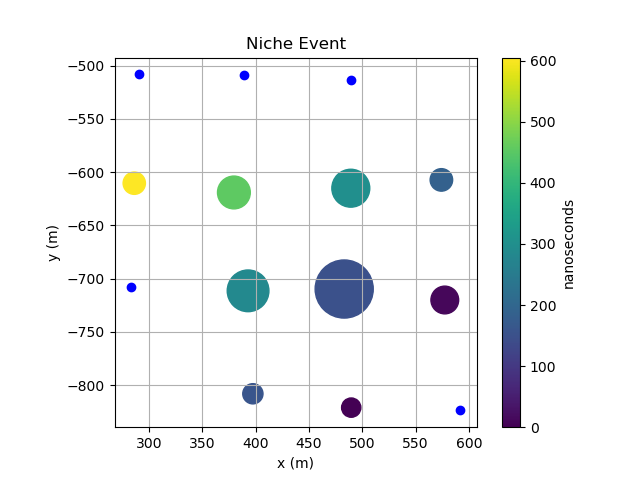

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
guess = make_guess(ty, pf)
# for i,p in enumerate(guess):
#     guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=300.0, limits=(300.0, 600.0), error=50.0)
FitParam(name='nmax', value=100000.0, limits=(100000.0, 10000000.0), error=100000.0)
FitParam(name='zenith', value=0.7477139521191707, limits=(0.6477139521191707, 0.8477139521191707), error=0.017453292519943295)
FitParam(name='azimuth', value=5.436574286540395, limits=(5.336574286540396, 5.536574286540395), error=0.017453292519943295)
FitParam(name='corex', value=449.0059370401787, limits=(379.5, 489.2), error=5.0)
FitParam(name='corey', value=-679.474447001357, limits=(-711.4, -615.1), error=5.0)
FitParam(name='corez', value=-25.7, limits=(-26.66702619221118, -24.66702619221118), error=1.0)
FitParam(name='x0', value=0.0, limits=(-100, 100), error=1)
FitParam(name='lambda', value=70.0, limits=(0, 100), error=1)
FitParam(name='t_offset', value=100.0, limits=(0, 150.0), error=10.0)


In [6]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

Now that we're reasonably close to the minimum, we can zero in on it by freeing all the parameters simultaneously.

In [7]:
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['xmax','nmax','zenith','azimuth','corex','corey','t_offset']
m = init_minuit(at, guess)
# m = init_minuit(at, guess)
# m.tol=5
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.601e+04 (χ²/ndof = 266.0)│              Nfcn = 108              │
│ EDM = 6.08e+04 (Goal: 0.1)       │           time = 204.4 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │   436.8   │    0.4    │            │            │   300   │   600   │       │
│ 1 │ nmax     │  3.123e6  │  0.011e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │ 716.58e-3 │  0.07e-3  │            │            │0.647714 │0.847714 │       │
│ 3 │ azimuth  │ 5.536487  │ 0.000013  │            │            │ 5.33657 │ 5.53657 │       │
│ 4 │ corex    │  445.370  │   0.012   │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -646.35  │   0.06    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │ -26.667 │ -24.667 │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │    0    │   100   │  yes  │
│ 9 │ t_offset │  105.85   │   0.04    │            │            │    0    │   150   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [8]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.527e+04 (χ²/ndof = 88.2) │              Nfcn = 948              │
│ EDM = 1.29e+08 (Goal: 0.0002)    │          time = 1260.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │  0.46e3   │  0.22e3   │            │            │   300   │   600   │       │
│ 1 │ nmax     │ 2.8590e6  │ 0.0006e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │716.57869e-3│0.00004e-3 │            │            │0.647714 │0.847714 │       │
│ 3 │ azimuth  │5.49513894 │0.00000006 │            │            │ 5.33657 │ 5.53657 │       │
│ 4 │ corex    │447.114299 │ 0.000014  │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │-646.35444 │  0.00007  │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │ -26.667 │ -24.667 │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │    0    │   100   │  yes  │
│ 9 │ t_offset │105.848240 │ 0.000031  │            │            │    0    │   150   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│          │              xmax              nmax            zenith           azimuth             corex             corey             corez                x0            lambda          t_offset │
├──────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │          6.67e+06             1.6e6 -75.3795175961e-6 -118.499836952e-6   -27.85911045e-3    -171.529930e-3               0e6               0e6               0e6    -64.9504942e-3 │
│     nmax │             1.6e6          4.05e+05 -18.5657528824e-6  -29.186160553e-6    -6.86161668e-3     -42.247312e-3                 0                 0                 0    -15.9971149e-3 │
│   zenith │ -75.3795175961e-6 -18.5657528824e-6          1.37e-15           1.6e-15         365.1e-15        2.0170e-12                 0                 0                 0         842.8e-15 │
│  azimuth │ -118.499836952e-6  -29.186160553e-6           1.6e-15          3.58e-15           580e-15         3.180e-12             0e-15             0e-15             0e-15         1.338e-12 │
│    corex │   -27.85911045e-3    -6.86161668e-3         365.1e-15           580e-15          1.82e-10           0.74e-9                 0                 0                 0           0.31e-9 │
│    corey │    -171.529930e-3     -42.247312e-3        2.0170e-12         3.180e-12           0.74e-9          4.57e-09              0e-9              0e-9              0e-9            1.7e-9 │
│ 

In [9]:
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.527e+04 (χ²/ndof = 88.2) │              Nfcn = 948              │
│ EDM = 1.29e+08 (Goal: 0.0002)    │          time = 1260.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │  0.46e3   │  0.22e3   │            │            │   300   │   600   │       │
│ 1 │ nmax     │ 2.8590e6  │ 0.0006e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │716.57869e-3│0.00004e-3 │            │            │0.647714 │0.847714 │       │
│ 3 │ azimuth  │5.49513894 │0.00000006 │            │            │ 5.33657 │ 5.53657 │       │
│ 4 │ corex    │447.114299 │ 0.000014  │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │-646.35444 │  0.00007  │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │ -26.667 │ -24.667 │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │    0    │   100   │  yes  │
│ 9 │ t_offset │105.848240 │ 0.000031  │            │            │    0    │   150   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│          │              xmax              nmax            zenith           azimuth             corex             corey             corez                x0            lambda          t_offset │
├──────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │          6.67e+06             1.6e6 -75.3795175961e-6 -118.499836952e-6   -27.85911045e-3    -171.529930e-3               0e6               0e6               0e6    -64.9504942e-3 │
│     nmax │             1.6e6          4.05e+05 -18.5657528824e-6  -29.186160553e-6    -6.86161668e-3     -42.247312e-3                 0                 0                 0    -15.9971149e-3 │
│   zenith │ -75.3795175961e-6 -18.5657528824e-6          1.37e-15           1.6e-15         365.1e-15        2.0170e-12                 0                 0                 0         842.8e-15 │
│  azimuth │ -118.499836952e-6  -29.186160553e-6           1.6e-15          3.58e-15           580e-15         3.180e-12             0e-15             0e-15             0e-15         1.338e-12 │
│    corex │   -27.85911045e-3    -6.86161668e-3         365.1e-15           580e-15          1.82e-10           0.74e-9                 0                 0                 0           0.31e-9 │
│    corey │    -171.529930e-3     -42.247312e-3        2.0170e-12         3.180e-12           0.74e-9          4.57e-09              0e-9              0e-9              0e-9            1.7e-9 │
│ 